In [2]:
#https://bond-kirill-alexandrovich.medium.com/approximation-of-image-sequences-9a8a34b93caf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [3]:
#For cv2
#!pip install opencv-python

import os
import cv2
import numpy as np

directory = 'CWDVA-main/IMGS_BY_YEAR'
width = 288
height = 288
images = np.empty(shape=(0, height, width, 3), dtype='uint8')
lst= os.listdir(directory)
lst.sort()
for i in range(0, len(os.listdir(directory))):
    image = cv2.imread(directory + '/' + lst[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (height, width))
    images = np.append(images, [image/255], axis=0)
print(images.shape)


(12, 288, 288, 3)


In [80]:
lst

['afull_state_grid_year1.png',
 'bfull_state_grid_year2.png',
 'cfull_state_grid_year3.png',
 'dfull_state_grid_year4.png',
 'efull_state_grid_year5.png',
 'ffull_state_grid_year6.png',
 'gfull_state_grid_year7.png',
 'hfull_state_grid_year8.png',
 'ifull_state_grid_year9.png',
 'jgfull_state_grid_year10.png',
 'kgfull_state_grid_year11.png',
 'lgfull_state_grid_year12.png']

In [4]:
from keras.applications import VGG16
from keras import Input, Model
from keras.layers import Flatten


def get_model(h, w):
    c_m = VGG16(weights='imagenet', include_top=False)
    custom_input = Input(shape=(h, w, 3), name='image_input')
    convolutional_input = c_m(custom_input)
    x = Flatten(name='flatten')(convolutional_input)
    my_model = Model(inputs=custom_input, outputs=x)
    return my_model


convolution_model = get_model(height, width)

In [71]:
print(convolution_model.predict(np.array([images[0]])).shape)

(1, 41472)


In [72]:
convoluted_array = np.empty(shape=(0, 41472))
for j in range(0, len(images)):
    pred = convolution_model.predict(np.array([images[j]]))
    convoluted_array = np.append(convoluted_array, pred, axis=0)
print(convoluted_array.shape)

(12, 41472)


In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
pca.fit(convoluted_array)
print(pca.n_components_)

8


In [74]:
decomposed_array = pca.transform(convoluted_array)
print(decomposed_array.shape)

(12, 8)


In [75]:
max_length = 12
n_features = 8
X = np.empty(shape=(0, max_length, n_features))
y = np.empty(shape=(0, n_features))
c = 0
def pad_seq(im_seq, max_len):
    empty = np.zeros(im_seq[0].shape)
    result = []
    ep = [empty] * (max_len - len(im_seq))
    for i in range(0, len(ep)):
        result.append(ep[i])
    for i in range(0, len(im_seq)):
        result.append(im_seq[i])
    return np.array(result, dtype='float64')


for i in range(0, len(decomposed_array) - 1):
    inp = decomposed_array[0:c + 1]
    inp = pad_seq(inp, max_length)
    target = decomposed_array[c + 1]
    X = np.append(X, [inp], axis=0)
    y = np.append(y, [target], axis=0)
    c += 1
print(X.shape)
print(y.shape)

(11, 12, 8)
(11, 8)


In [5]:
from keras import Sequential
from keras.layers import LSTM, Dense, InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(max_length, n_features)))
model.add(LSTM(units=16, dropout=0.2))
model.add(Dense(n_features, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
h = model.fit(X, y, validation_split=0.2, epochs=3000, verbose=1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.show()

NameError: name 'max_length' is not defined

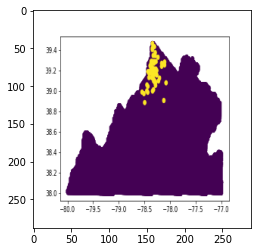

In [125]:
test_image = cv2.imread(directory + '/' + lst[11])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (height, width))
plt.imshow(test_image)
plt.show()

In [126]:
from sklearn.preprocessing import normalize
pred = convolution_model.predict(np.array([test_image]))
pred = pca.transform(pred)
pred = normalize(pred)
pred = np.array([pad_seq(pred, max_length)])


hfull_state_grid_year8.png


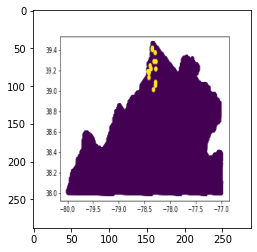

In [127]:
from sklearn.metrics import mean_squared_error
pred = model.predict(pred)

scores = np.empty(0)

for i in range(0, len(decomposed_array)):
    scores = np.append(scores, mean_squared_error(decomposed_array[i], pred[0]))
ims_pics = lst
index = np.argmin(scores)
image = cv2.imread(directory + '/' + ims_pics[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (height, width))
print(ims_pics[index])
plt.imshow(image)
plt.show()

In [136]:
#https://keras.io/examples/vision/conv_lstm/
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 288, 288, 3)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [20]:
images = images.reshape(1,12,288,288,3)

In [138]:
epochs = 1  # In practice, you would need hundreds of epochs.

seq.fit(
    images,
    images,
    batch_size=1,
    epochs=epochs,
    verbose=2,
    #validation_split=0.1,
)

ValueError: in user code:

    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((1, 12, 288, 288, 1) vs (1, 12, 288, 288, 3))


In [17]:
from keras.layers import TimeDistributed
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D

model = Sequential()
model.add(TimeDistributed(Conv2D(filters=6, 
                                 kernel_size=3,
                                 strides=1,
                                 activation='relu'), 
                                 batch_input_shape=(1,12,288,288,3)))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, stateful=True))
#model.add(LSTM(10, stateful=True))
model.add(Dense(1))
model.compile(optimizer='adam', metrics=['accuracy'])

In [21]:
history = model.fit(images, 
                    images,
                    epochs=50, 
                    batch_size=1,
                    #class_weight=class_weights,
                    #validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/50


ValueError: in user code:

    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:598 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:79 filter_empty_gradients
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['time_distributed_23/kernel:0', 'time_distributed_23/bias:0', 'time_distributed_24/kernel:0', 'time_distributed_24/bias:0', 'lstm_9/lstm_cell_9/kernel:0', 'lstm_9/lstm_cell_9/recurrent_kernel:0', 'lstm_9/lstm_cell_9/bias:0', 'dense/kernel:0', 'dense/bias:0'].
